# Preprocessing and Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [3]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import re
import warnings
warnings.filterwarnings("ignore")


In [4]:
airbnb = pd.read_csv('listings_montreal_transformed.csv', index_col=0)
airbnb.head()

,host_id,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,number_bedrooms,number_beds,number_bath,shared_bathrooms
0,753212,Le Plateau-Mont-Royal,Private room,21.0,31,13,0.34,3,286,0,1.0,1.0,1.0,True
1,202884942,Rosemont-La Petite-Patrie,Entire home/apt,40.0,90,0,0.00,1,0,0,1.0,1.0,1.0,False
2,65607998,Verdun,Entire home/apt,55.0,31,0,0.00,1,27,0,1.0,1.0,1.0,False
3,368730072,Ville-Marie,Entire home/apt,160.0,31,0,0.00,1,364,0,2.0,2.0,1.0,False
4,162017221,Ville-Marie,Entire home/apt,60.0,31,4,0.39,2,0,4,1.0,1.0,1.0,False


In [5]:
airbnb['shared_bathrooms'] = airbnb['shared_bathrooms'].astype(str)

In [6]:
print(airbnb.dtypes)

host_id                             int64
neighbourhood                      object
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
number_bedrooms                   float64
number_beds                       float64
number_bath                       float64
shared_bathrooms                   object
dtype: object


In [7]:
# Convert categorical variables into factors
airbnb['room_type'] = pd.factorize(airbnb['room_type'])[0]
airbnb['neighbourhood'] = pd.factorize(airbnb['neighbourhood'])[0]


In [8]:
# Replace inf values with NaN and drop rows with any NaN values
airbnb.replace([np.inf, -np.inf], np.nan, inplace=True)

In [9]:
X = airbnb.drop(columns=['host_id', 'price', 'number_of_reviews_ltm','calculated_host_listings_count','number_of_reviews', 'reviews_per_month', 'availability_365'])
y = airbnb['price']

In [10]:
# Identify columns with null values
null_columns = airbnb.columns[airbnb.isnull().any()]
print("Columns with null values:", null_columns)

Columns with null values: Index(['number_bedrooms', 'number_beds', 'number_bath'], dtype='object')


In [11]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'bool', 'category']).columns


In [13]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [14]:
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])


In [15]:
# Combine pipelines with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])


# Modeling
## 1. Multiple Linear Regression

In [16]:
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [17]:
# Fit the pipeline on the training set
lr_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['neighbourhood', 'room_type', 'minimum_nights', 'number_bedrooms',
       'number_beds', 'number_bath'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['shared_bathrooms'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [18]:
r_sq = lr_model.score(X_train, y_train)
print(f"coefficient of determination: {r_sq *100:.2f}%")

coefficient of determination: 7.02%


In [19]:
# Check the predictions against the actual values
train_pred = lr_model.predict(X_train)
test_pred = lr_model.predict(X_test)

In [20]:
# Reporting
print("Training RMSE:", round(mean_squared_error(y_train, train_pred, squared=False), 3))
print("Training R^2:", round(r2_score(y_train, train_pred), 3))
print("\nValidation RMSE:", round(mean_squared_error(y_test, test_pred, squared=False), 3))
print("Validation R^2:", round(r2_score(y_test, test_pred), 3))

Training RMSE: 1290.525
Training R^2: 0.07

Validation RMSE: 485.056
Validation R^2: -0.789


The linear regression analysis on the Airbnb Montreal dataset reveals insights into how various factors influence listing prices. Despite adjustments to the feature set to diminish noise, the model demonstrated modest explanatory power, with an R-squared value of 0.07 on the training set, suggesting it captures only a small fraction of the variance in prices. This limited performance indicates that while the model can identify some patterns in the data, its predictive accuracy is constrained, as further evidenced by the negative R-squared value on the validation set.


### Using Log Price in Linear Regression

In [21]:
airbnb['log_price'] = np.log(airbnb['price'])

In [22]:
X = airbnb.drop(columns=['host_id', 'price', 'number_of_reviews_ltm', 'calculated_host_listings_count', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'log_price'])
y_log = airbnb['log_price']

In [23]:
X_train, X_test, y_log_train, y_log_test = train_test_split(X, y_log, test_size=0.20, random_state=42)


In [24]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Create numeric and categorical pipelines
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Create a full pipeline with the preprocessor and an estimator
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline on the training set using log_price
lr_model.fit(X_train, y_log_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['neighbourhood', 'room_type', 'minimum_nights', 'number_bedrooms',
       'number_beds', 'number_bath'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['shared_bathrooms'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [25]:
train_pred = lr_model.predict(X_train)
test_pred = lr_model.predict(X_test)

In [27]:
print("Training RMSE (log scale):", round(mean_squared_error(y_log_train, train_pred, squared=False), 3))
print("Training R-squared (log scale):", round(r2_score(y_log_train, train_pred), 3))
print("\nValidation RMSE (log scale):", round(mean_squared_error(y_log_test, test_pred, squared=False), 3))
print("Validation R-squared (log scale):", round(r2_score(y_log_test, test_pred), 3))


Training RMSE (log scale): 0.548
Training R-squared (log scale): 0.386

Validation RMSE (log scale): 0.55
Validation R-squared (log scale): 0.396


The use of log_price has evidently enhanced the model's ability to capture and explain the variability in Airbnb listing prices, leading to a more reliable and interpretable model. The relatively close training and validation RMSE values suggest that the model is stable and generalizes well to unseen data, without substantial overfitting. Meanwhile, the R-squared values, though not high, mark a considerable improvement, indicating that the model, with its current features and transformations, captures a significant portion of the pricing dynamics in the dataset.

However, there's still room for improvement, as more than 60% of the variability remains unexplained by the model.

Cross Validation for feature selection

In [31]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score


In [32]:
# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Transform the training and test data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [33]:
# Initialize the base model
base_model = LinearRegression()

# Initialize RFE with the base model
rfe = RFE(estimator=base_model)

# Define the parameter grid for 'n_features_to_select'
param_grid = {'n_features_to_select': list(range(1, X_train_transformed.shape[1] + 1))}

# Initialize KFold for cross-validation
folds = KFold(n_splits=10, shuffle=True, random_state=42)


In [34]:
# Initialize GridSearchCV with RFE
model_cv = GridSearchCV(estimator=rfe, param_grid=param_grid, scoring='r2', cv=folds, verbose=1, return_train_score=True)


In [35]:
# Fit GridSearchCV
model_cv.fit(X_train_transformed, y_log_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid={'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True, scoring='r2', verbose=1)

In [36]:
# Best number of features
print("Best number of features:", model_cv.best_estimator_.n_features_to_select)


Best number of features: 7


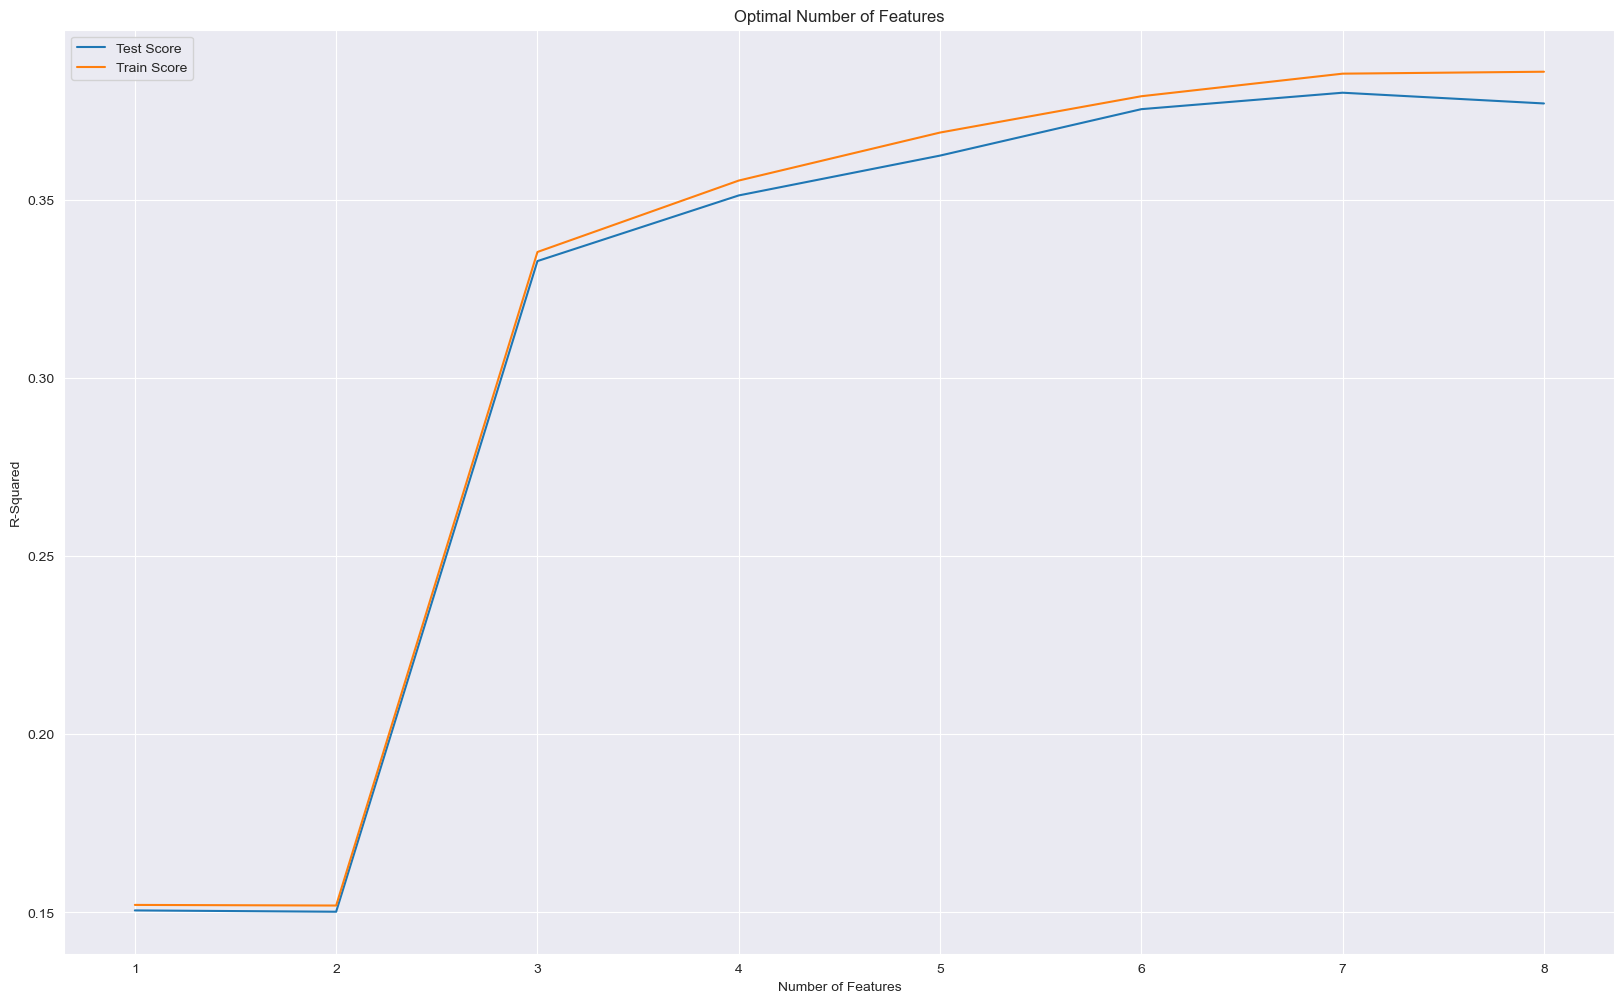

In [37]:
# Plotting CV results
cv_results = pd.DataFrame(model_cv.cv_results_)
plt.figure(figsize=(20, 12))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"], label='Test Score')
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"], label='Train Score')
plt.xlabel('Number of Features')
plt.ylabel('R-Squared')
plt.title("Optimal Number of Features")
plt.legend(loc='upper left')
plt.show()

In [38]:
# Use the best model to make predictions on the test data
y_log_pred = model_cv.predict(X_test_transformed)

# Calculate and print the R-squared value
print("Test R-squared:", r2_score(y_log_test, y_log_pred))

Test R-squared: 0.39344681944567916


Applying models like Ridge or Lasso regression could help improve model performance by penalizing less important features.

## 2. LASSO Regression with Log Price

In [39]:
# Define the Lasso pipeline (using your preprocessor for numeric and categorical features)
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])


In [40]:
# Set up GridSearchCV to find the best alpha
param_grid = {'regressor__alpha': np.arange(0.01, 1, 0.01)}
grid_search = GridSearchCV(lasso_pipeline, param_grid, cv=8, scoring="neg_mean_squared_error", verbose=3)

# Fit the model
grid_search.fit(X_train, y_log_train)

# Best alpha value
print("Best alpha:", grid_search.best_params_)


Fitting 8 folds for each of 99 candidates, totalling 792 fits
[CV 1/8] END ............regressor__alpha=0.01;, score=-0.331 total time=   0.0s
[CV 2/8] END ............regressor__alpha=0.01;, score=-0.292 total time=   0.0s
[CV 3/8] END ............regressor__alpha=0.01;, score=-0.307 total time=   0.0s
[CV 4/8] END ............regressor__alpha=0.01;, score=-0.295 total time=   0.0s
[CV 5/8] END ............regressor__alpha=0.01;, score=-0.303 total time=   0.0s
[CV 6/8] END ............regressor__alpha=0.01;, score=-0.389 total time=   0.0s
[CV 7/8] END ............regressor__alpha=0.01;, score=-0.251 total time=   0.0s
[CV 8/8] END ............regressor__alpha=0.01;, score=-0.276 total time=   0.0s
[CV 1/8] END ............regressor__alpha=0.02;, score=-0.337 total time=   0.0s
[CV 2/8] END ............regressor__alpha=0.02;, score=-0.297 total time=   0.0s
[CV 3/8] END ............regressor__alpha=0.02;, score=-0.313 total time=   0.0s
[CV 4/8] END ............regressor__alpha=0.02;

In [41]:
# Predictions and evaluation on training data
y_log_train_pred = grid_search.predict(X_train)
train_mse = mean_squared_error(y_log_train, y_log_train_pred)
print("Training MSE:", train_mse)
print("Training RMSE:", np.sqrt(train_mse))
print("Training R2:", r2_score(y_log_train, y_log_train_pred))

# Predictions and evaluation on test data
y_log_test_pred = grid_search.predict(X_test)
test_mse = mean_squared_error(y_log_test, y_log_test_pred)
print("Test MSE:", test_mse)
print("Test RMSE:", np.sqrt(test_mse))
print("Test R2:", r2_score(y_log_test, y_log_test_pred))


Training MSE: 0.3022146061004857
Training RMSE: 0.5497404897772091
Training R2: 0.38271268479509735
Test MSE: 0.305006419899343
Test RMSE: 0.5522738631325431
Test R2: 0.39075118165191947


The Lasso regression model shows a reasonable degree of predictive ability, with a moderate R-squared value and relatively low MSE/RMSE values on both the training and test sets. The numbers in the training and testing sets are similar

Get the Optimum Value of Alpha

In [42]:

best_alpha = grid_search.best_params_['regressor__alpha']
print("Best alpha:", best_alpha)


Best alpha: 0.01


In [44]:
# Extract the coefficients from the Lasso model within the best estimator of the GridSearchCV
airbnb_lasso_coefficients = grid_search.best_estimator_.named_steps['regressor'].coef_

# Importance of features
airbnb_lasso_importance = np.abs(airbnb_lasso_coefficients)
print("Features with non-zero importance:", airbnb_lasso_importance > 0)


Features with non-zero importance: [ True  True  True  True  True  True  True  True]


In [45]:

try:
    feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
except AttributeError:
    feature_names = X_train.columns

# Features and their importance
lasso_importances = pd.DataFrame({
    'Attribute': feature_names,
    'Importance': airbnb_lasso_importance
})

# Sort features by their importance
lasso_importances_sorted = lasso_importances.sort_values(by='Importance', ascending=False)

print(lasso_importances_sorted)


                     Attribute    Importance
6  cat__shared_bathrooms_False  3.993652e-01
3         num__number_bedrooms  1.983569e-01
4             num__number_beds  1.084179e-01
1               num__room_type  1.024035e-01
0           num__neighbourhood  7.053581e-02
5             num__number_bath  5.240862e-02
2          num__minimum_nights  3.319034e-03
7   cat__shared_bathrooms_True  2.056106e-17




The optimal subset for feature selection is 7 variables, which have coefficients > 0 as Lasso imposes a higher level of penalty. It seems that the most important feature in predicting price is that the bathrooms are not shared but rather private.

## 3. Random Forest with Bagging

Using log_price as the outcome variable

In [46]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [47]:
# Fit the Random Forest regressor with OOB score enabled
rf_model = RandomForestRegressor(n_estimators=100, max_features='sqrt', bootstrap=True, oob_score=True, random_state=42)
rf_pipeline.set_params(regressor=rf_model)
rf_pipeline.fit(X_train, y_log_train)

# OOB score
print("OOB Score:", rf_model.oob_score_)


OOB Score: 0.480765066613294


OOB score of ~48% is promising, especially for preliminary model exploration.

Visualizing a single tree

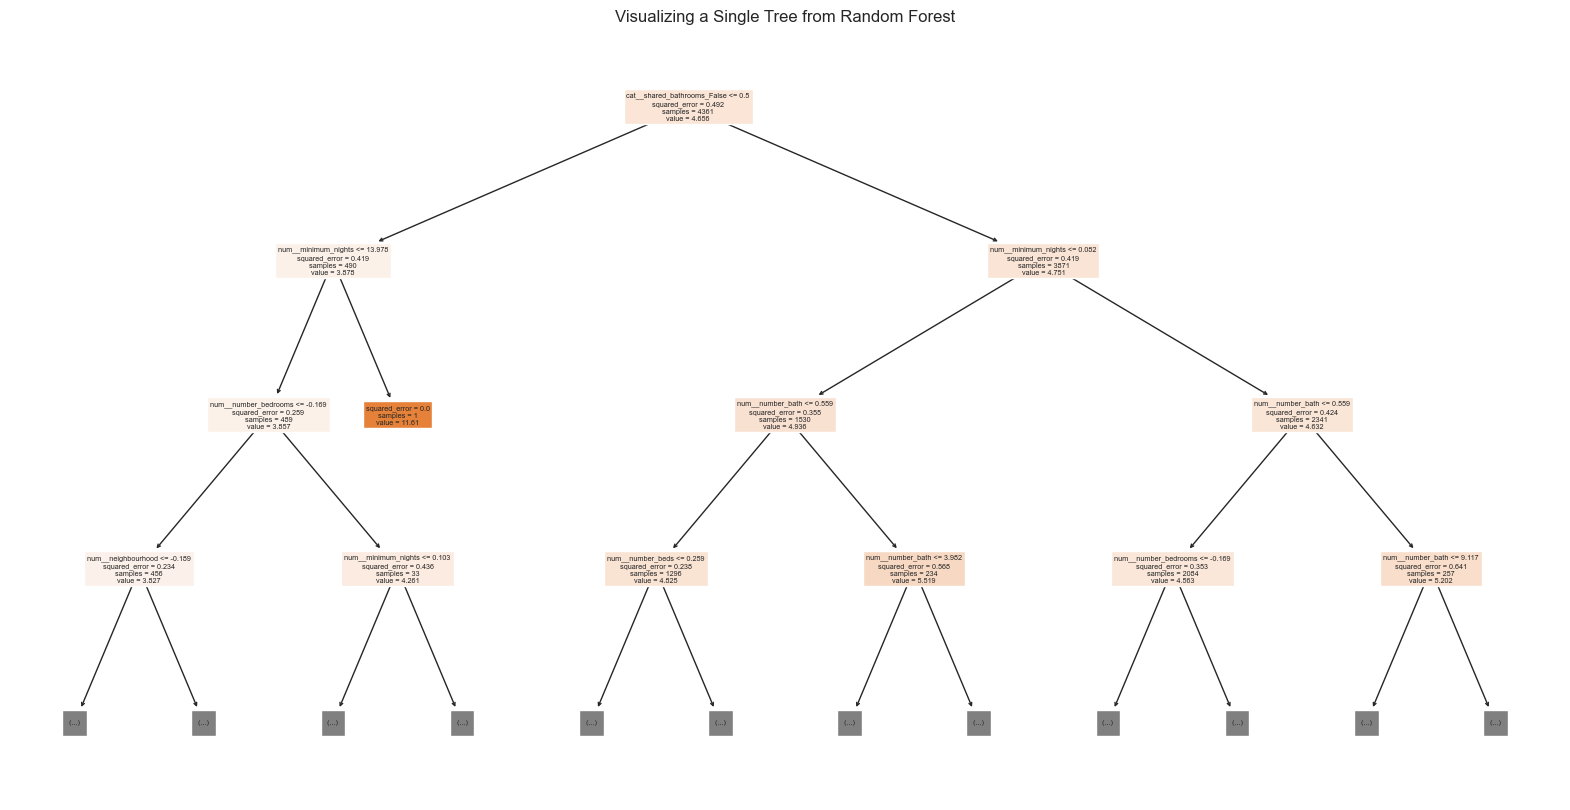

In [51]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


single_tree = rf_pipeline.named_steps['regressor'].estimators_[0]


plt.figure(figsize=(20, 10))
plot_tree(single_tree, feature_names=feature_names, max_depth=3, filled=True)
plt.title('Visualizing a Single Tree from Random Forest')
plt.show()

Evaluating Model Performance

In [48]:
# Predict on test data
y_log_pred = rf_pipeline.predict(X_test)

# Calculate R² and MSE on test data
print("Test R²:", r2_score(y_log_test, y_log_pred))
print("Test MSE:", mean_squared_error(y_log_test, y_log_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_log_test, y_log_pred)))


Test R²: 0.4862723179122972
Test MSE: 0.25718595817979356
Test RMSE: 0.5071350492519656


The model explains approximately 48.6% of the variance in log_price in the test dataset. This is a moderate score indicating that nearly half of the variability of log_price can be explained by the model. In addition, the model's predictions deviate from the actual log_price by about 0.507 units on the logarithmic scale.

Visualizing Features Importance

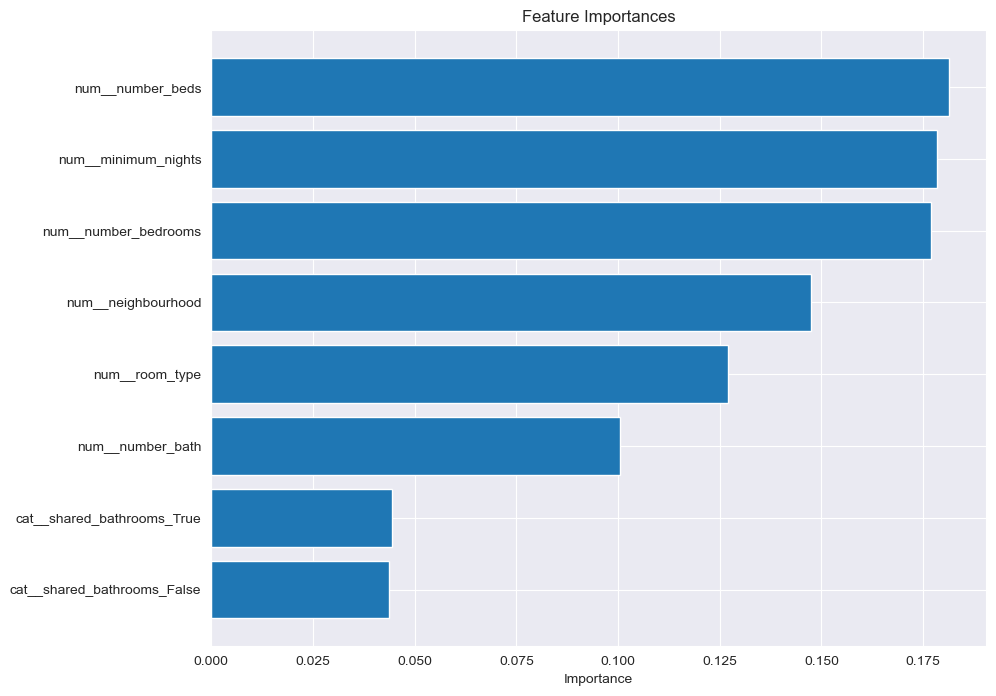

In [50]:
try:
    feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
except AttributeError:
    feature_names = X_train.columns

feature_importances = rf_pipeline.named_steps['regressor'].feature_importances_

importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(importances['Feature'][:20], importances['Importance'][:20])
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()


#### Evaluating the Models for Price Prediction (Log_Price):

In [52]:
data = {
    'Model': ['Linear Regression', 'Lasso Regression', 'Random Forest'],
    'R2': [0.486, 0.393, 0.486],
    'MSE': [0.257, 0.302, 0.257],
    'RMSE': [0.507, 0.549, 0.507]
}

# Create DataFrame
df_metrics = pd.DataFrame(data)

#### Plotting the metrics

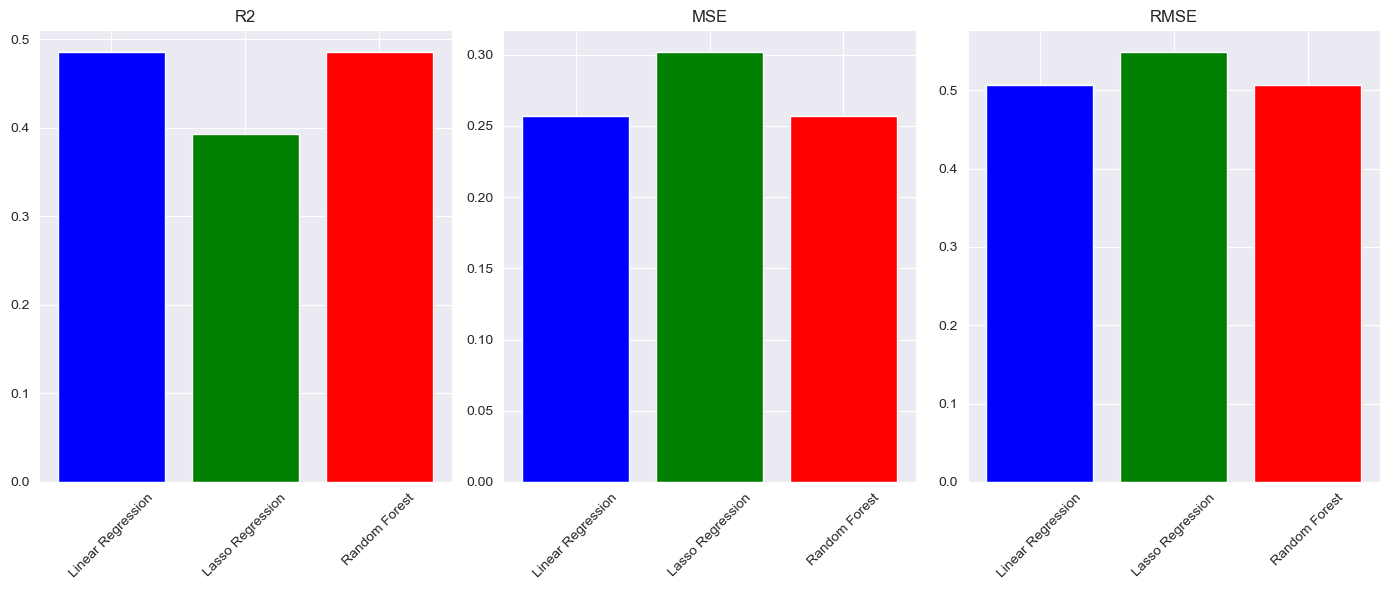

In [53]:
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Titles
metrics = ['R2', 'MSE', 'RMSE']

# Create subplots for each metric
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    plt.bar(df_metrics['Model'], df_metrics[metric], color=['blue', 'green', 'red'])
    plt.title(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

 Both Linear Regression and Random Forest demonstrated comparable and relatively strong performances, each explaining approximately 48.6% of the variance in log_price. Lasso Regression, while beneficial for its feature selection capabilities, lagged slightly behind in this context, with an R² of 0.393, indicating a lower capacity to explain the variance in log_price.
 Linear Regression offers a balance between simplicity and performance, Lasso provides a regularization advantage, and Random Forest captures complex nonlinear relationships.